<a href="https://colab.research.google.com/github/esrayuzgec/parkinsonvsalz/blob/main/PDCN_CONVNEXT__GRADCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
!pip install timm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:

from fastbook import *
import timm
from fastai.vision.all import *
from timm import create_model
from fastai.vision.learner import _update_first_layer

In [4]:
path = Path('/content/gdrive/MyDrive/3_cls')


In [5]:
path.ls()


(#14) [Path('/content/gdrive/MyDrive/3_cls/train'),Path('/content/gdrive/MyDrive/3_cls/test'),Path('/content/gdrive/MyDrive/3_cls/alzparkinson_2cls.pth'),Path('/content/gdrive/MyDrive/3_cls/parkinsonCN_resnet18_1.pth'),Path('/content/gdrive/MyDrive/3_cls/parkinsonCN_resnet18_1'),Path('/content/gdrive/MyDrive/3_cls/parkinsonCN_resnet18_1.pkl'),Path('/content/gdrive/MyDrive/3_cls/pdCNVGG16_1.pth'),Path('/content/gdrive/MyDrive/3_cls/pdCNVGG16_1.pkl'),Path('/content/gdrive/MyDrive/3_cls/PADCN_convnext.pth'),Path('/content/gdrive/MyDrive/3_cls/PADCN_convnext.pkl')...]

In [6]:


item_tfms = Resize(224)
batch_tfms = aug_transforms=[Normalize.from_stats(*imagenet_stats)]

In [7]:
all_files= get_image_files(path)


In [8]:

dblock=DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                 splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                 get_y=parent_label,
                 
                 item_tfms = Resize(224),
                 batch_tfms =[Normalize.from_stats(*imagenet_stats)]
              
                 
)

In [9]:
dls_test = dblock.dataloaders(all_files)


In [10]:
learn1 = vision_learner(dls_test, 'convnext_small_in22k', metrics=accuracy).load('/content/gdrive/MyDrive/3_cls/PADCN_convnext')


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


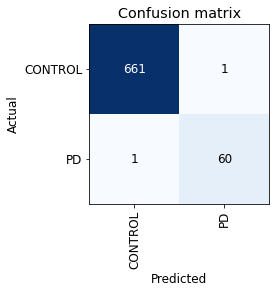

In [11]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()


In [12]:
losses,idxs = interp.top_losses(10)
print(idxs)

TensorBase([  9, 720,  44,  29,  18,  15,   2,  54,  24,  22])


In [20]:
dls_test.valid_ds.items[9]


Path('/content/gdrive/MyDrive/3_cls/test/PD/PD_358.png')

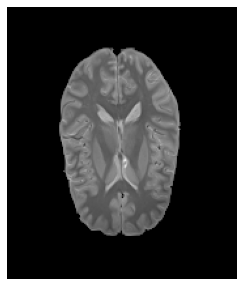

In [21]:

img = PILImage.create('/content/gdrive/MyDrive/3_cls/test/PD/PD_358.png')
img.show()
     

In [22]:

learn1.predict(img)

('CONTROL', TensorBase(0), TensorBase([0.9926, 0.0074]))

In [23]:
class HookActivation():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_activation` function."""

        self.hook = target_layer.register_forward_hook(self.hook_activation) 
        
    def hook_activation(self, target_layer, activ_in, activ_out): 
        """Create a copy of the layer output activations and save 
        in `self.stored`.
        """
        self.stored = activ_out.detach().clone()
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()

        
class HookGradient():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_gradient` function."""
        
        self.hook = target_layer.register_backward_hook(self.hook_gradient)   
        
    def hook_gradient(self, target_layer, gradient_in, gradient_out): 
        """Create a copy of the layer output gradients and save 
        in `self.stored`.
        """
        self.stored = gradient_out[0].detach().clone()
        
    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()

In [24]:

m = learn1.model.eval();
m;

In [25]:
target_layer = learn1.model[0]

target_layer;

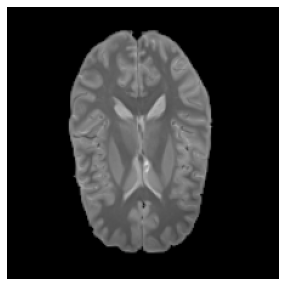

In [26]:
x, = first(dls_test.test_dl([img]))

x_img = TensorImage(dls_test.train.decode((x,))[0][0])
x_img.show()

In [27]:

class_Z = 1

with HookGradient(target_layer) as hookg:
    with HookActivation(target_layer) as hook:
        output = learn1.model.eval()(x.cuda())
        act = hook.stored
    output[0, class_Z].backward()
    grad = hookg.stored
    p0, p1 = output.cpu().detach()[0]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [28]:

w = grad[0].mean(dim=(1,2), keepdim=True)
gradcam_map = (w * act[0]).sum(0).detach().cpu()
     

In [29]:
def plot_gradcam(img, learn1, hooked_layer, size=224):
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)

    x_img = TensorImage(dls_test.train.decode((x,))[0][0])
    
    
    for i, ax in zip([0, 2, 1], axes):

        if i == 0:
            x_img.show(ax=ax)
            ax.set_axis_off()
            continue

        with HookGradient(hooked_layer) as hookg:
            with HookActivation(hooked_layer) as hook:
                output = learn1.model.eval()(x.cuda())
                act = hook.stored
            output[0, i-1].backward()
            grad = hookg.stored
            p_high, p_low = output.cpu().detach()[0]

        w = grad[0].mean(dim=(1,2), keepdim=True)
        gradcam_map = (w * act[0]).sum(0).detach().cpu()

        # thresholding to account for ReLU
        gradcam_map = torch.clamp(gradcam_map, min=0) 

        x_img.show(ax=ax)
        ax.imshow(
            gradcam_map, alpha=0.6, extent=(0, size, size,0),
            interpolation='mitchell', cmap='hot'
        )
        ax.set_axis_off()
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    
    return (fig, axes, *(np.exp([p_low, p_high]) / np.exp([p_low, p_high]).sum()))
     

HATALI TAHMİN GRADCAM

(<Figure size 1275x450 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f25c04d66d0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f25c04ae6a0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f25c04597f0>], dtype=object),
 0.0074249045,
 0.9925751)

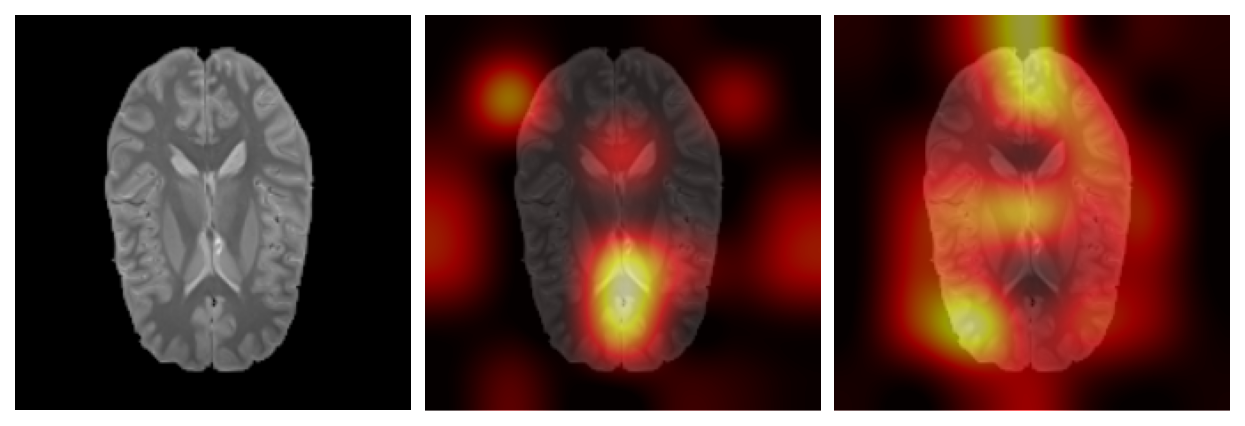

In [30]:


plot_gradcam(x_img,learn1,target_layer)

HATALI TAHMİN GRADCAM 2

In [31]:


dls_test.valid_ds.items[720]

Path('/content/gdrive/MyDrive/3_cls/test/CONTROL/CONTROL_PD_171.png')

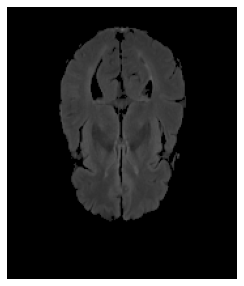

In [32]:

img = PILImage.create('/content/gdrive/MyDrive/3_cls/test/CONTROL/CONTROL_PD_171.png')
img.show()

In [33]:



learn1.predict(img)
     

('PD', TensorBase(1), TensorBase([0.0402, 0.9598]))

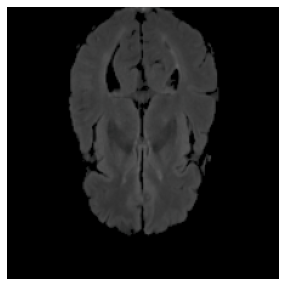

In [34]:

class HookActivation():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_activation` function."""

        self.hook = target_layer.register_forward_hook(self.hook_activation) 
        
    def hook_activation(self, target_layer, activ_in, activ_out): 
        """Create a copy of the layer output activations and save 
        in `self.stored`.
        """
        self.stored = activ_out.detach().clone()
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()

        
class HookGradient():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_gradient` function."""
        
        self.hook = target_layer.register_backward_hook(self.hook_gradient)   
        
    def hook_gradient(self, target_layer, gradient_in, gradient_out): 
        """Create a copy of the layer output gradients and save 
        in `self.stored`.
        """
        self.stored = gradient_out[0].detach().clone()
        
    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()
     


m = learn1.model.eval();
m;
     

target_layer = learn1.model[0]
target_layer;
     

x, = first(dls_test.test_dl([img]))

x_img = TensorImage(dls_test.train.decode((x,))[0][0])
x_img.show()

In [35]:
class_Z = 1

with HookGradient(target_layer) as hookg:
    with HookActivation(target_layer) as hook:
        output = learn1.model.eval()(x.cuda())
        act = hook.stored
    output[0, class_Z].backward()
    grad = hookg.stored
    p0, p1 = output.cpu().detach()[0]
     

w = grad[0].mean(dim=(1,2), keepdim=True)
gradcam_map = (w * act[0]).sum(0).detach().cpu()
     

def plot_gradcam(img, learn1, hooked_layer, size=224):
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)

    x_img = TensorImage(dls_test.train.decode((x,))[0][0])
    
    
    for i, ax in zip([0, 2, 1], axes):

        if i == 0:
            x_img.show(ax=ax)
            ax.set_axis_off()
            continue

        with HookGradient(hooked_layer) as hookg:
            with HookActivation(hooked_layer) as hook:
                output = learn1.model.eval()(x.cuda())
                act = hook.stored
            output[0, i-1].backward()
            grad = hookg.stored
            p_high, p_low = output.cpu().detach()[0]

        w = grad[0].mean(dim=(1,2), keepdim=True)
        gradcam_map = (w * act[0]).sum(0).detach().cpu()

        # thresholding to account for ReLU
        gradcam_map = torch.clamp(gradcam_map, min=0) 

        x_img.show(ax=ax)
        ax.imshow(
            gradcam_map, alpha=0.6, extent=(0, size, size,0),
            interpolation='mitchell', cmap='hot'
        )
        ax.set_axis_off()
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    
    return (fig, axes, *(np.exp([p_low, p_high]) / np.exp([p_low, p_high]).sum()))

(<Figure size 1275x450 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f25c0311280>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f25c0333ac0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f25c02de070>], dtype=object),
 0.95975024,
 0.040249765)

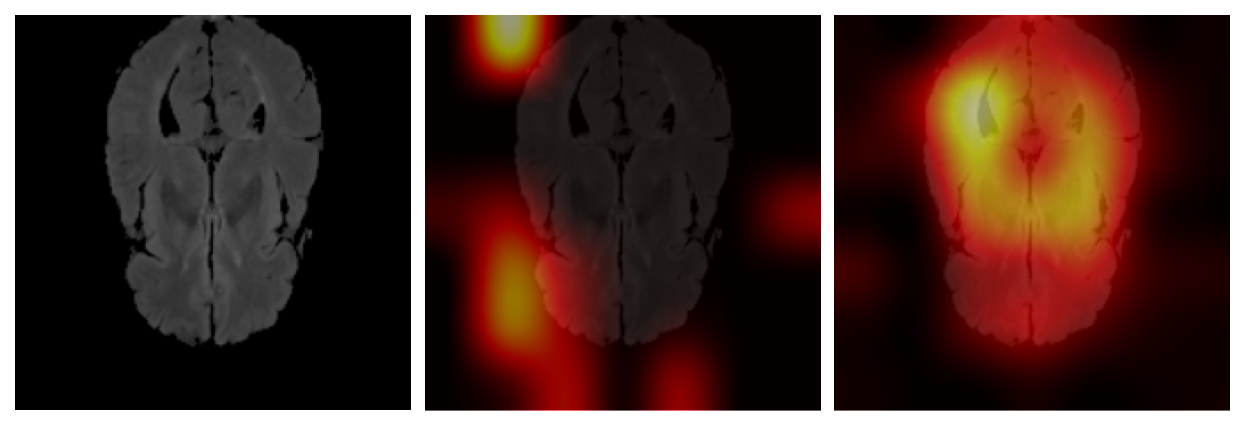

In [36]:
plot_gradcam(x_img,learn1,target_layer)

DOĞRU TAHMİN GRADCAM

In [37]:
dls_test.valid_ds.items[5]

Path('/content/gdrive/MyDrive/3_cls/test/PD/PD_355.png')

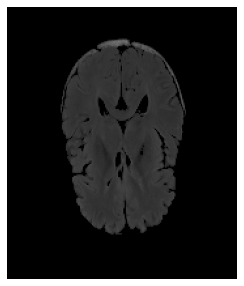

In [40]:

img = PILImage.create('/content/gdrive/MyDrive/3_cls/test/PD/PD_355.png')
img.show()

In [41]:


learn1.predict(img)

('PD', TensorBase(1), TensorBase([6.5368e-06, 9.9999e-01]))

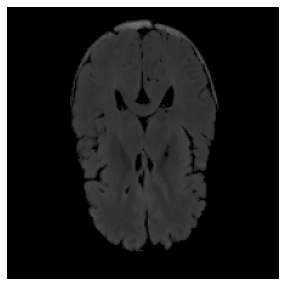

In [42]:
class HookActivation():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_activation` function."""

        self.hook = target_layer.register_forward_hook(self.hook_activation) 
        
    def hook_activation(self, target_layer, activ_in, activ_out): 
        """Create a copy of the layer output activations and save 
        in `self.stored`.
        """
        self.stored = activ_out.detach().clone()
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()

        
class HookGradient():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_gradient` function."""
        
        self.hook = target_layer.register_backward_hook(self.hook_gradient)   
        
    def hook_gradient(self, target_layer, gradient_in, gradient_out): 
        """Create a copy of the layer output gradients and save 
        in `self.stored`.
        """
        self.stored = gradient_out[0].detach().clone()
        
    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()
     


m = learn1.model.eval();
m;
     

target_layer = learn1.model[0]
target_layer;
     

x, = first(dls_test.test_dl([img]))

x_img = TensorImage(dls_test.train.decode((x,))[0][0])
x_img.show()
     

In [43]:
class_Z = 1

with HookGradient(target_layer) as hookg:
    with HookActivation(target_layer) as hook:
        output = learn1.model.eval()(x.cuda())
        act = hook.stored
    output[0, class_Z].backward()
    grad = hookg.stored
    p0, p1 = output.cpu().detach()[0]
     

w = grad[0].mean(dim=(1,2), keepdim=True)
gradcam_map = (w * act[0]).sum(0).detach().cpu()
     

def plot_gradcam(img, learn1, hooked_layer, size=224):
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)

    x_img = TensorImage(dls_test.train.decode((x,))[0][0])
    
    
    for i, ax in zip([0, 2, 1], axes):

        if i == 0:
            x_img.show(ax=ax)
            ax.set_axis_off()
            continue

        with HookGradient(hooked_layer) as hookg:
            with HookActivation(hooked_layer) as hook:
                output = learn1.model.eval()(x.cuda())
                act = hook.stored
            output[0, i-1].backward()
            grad = hookg.stored
            p_high, p_low = output.cpu().detach()[0]

        w = grad[0].mean(dim=(1,2), keepdim=True)
        gradcam_map = (w * act[0]).sum(0).detach().cpu()

        # thresholding to account for ReLU
        gradcam_map = torch.clamp(gradcam_map, min=0) 

        x_img.show(ax=ax)
        ax.imshow(
            gradcam_map, alpha=0.6, extent=(0, size, size,0),
            interpolation='mitchell', cmap='hot'
        )
        ax.set_axis_off()
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    
    return (fig, axes, *(np.exp([p_low, p_high]) / np.exp([p_low, p_high]).sum()))

(<Figure size 1275x450 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f25c01adac0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f25c015f070>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f25c0117400>], dtype=object),
 0.9999935,
 6.5367926e-06)

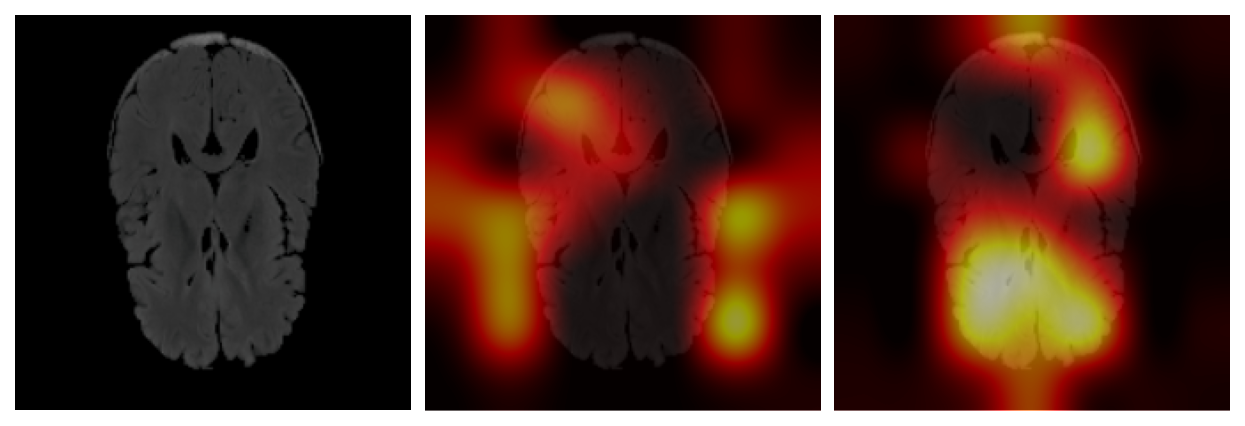

In [44]:
plot_gradcam(x_img,learn1,target_layer)

In [62]:
dls_test.valid_ds.items[15]
     

Path('/content/gdrive/MyDrive/3_cls/test/PD/PD_348.png')

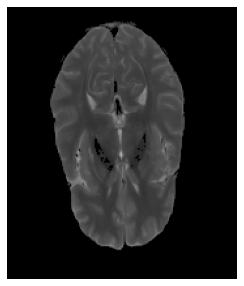

In [63]:
img = PILImage.create('/content/gdrive/MyDrive/3_cls/test/PD/PD_348.png')
img.show()

In [64]:

learn1.predict(img)

('PD', TensorBase(1), TensorBase([9.2613e-05, 9.9991e-01]))

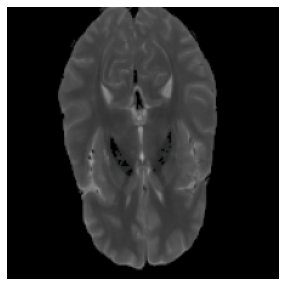

In [65]:
class HookActivation():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_activation` function."""

        self.hook = target_layer.register_forward_hook(self.hook_activation) 
        
    def hook_activation(self, target_layer, activ_in, activ_out): 
        """Create a copy of the layer output activations and save 
        in `self.stored`.
        """
        self.stored = activ_out.detach().clone()
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()

        
class HookGradient():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_gradient` function."""
        
        self.hook = target_layer.register_backward_hook(self.hook_gradient)   
        
    def hook_gradient(self, target_layer, gradient_in, gradient_out): 
        """Create a copy of the layer output gradients and save 
        in `self.stored`.
        """
        self.stored = gradient_out[0].detach().clone()
        
    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()
     

m = learn1.model.eval();
m;
     

target_layer = learn1.model[0]

target_layer;
     


x, = first(dls_test.test_dl([img]))

x_img = TensorImage(dls_test.train.decode((x,))[0][0])
x_img.show()

In [66]:
class_Z = 1

with HookGradient(target_layer) as hookg:
    with HookActivation(target_layer) as hook:
        output = learn1.model.eval()(x.cuda())
        act = hook.stored
    output[0, class_Z].backward()
    grad = hookg.stored
    p0, p1 = output.cpu().detach()[0]
     


w = grad[0].mean(dim=(1,2), keepdim=True)
gradcam_map = (w * act[0]).sum(0).detach().cpu()
     

def plot_gradcam(img, learn1, hooked_layer, size=224):
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)

    x_img = TensorImage(dls_test.train.decode((x,))[0][0])
    
    
    for i, ax in zip([0, 2, 1], axes):

        if i == 0:
            x_img.show(ax=ax)
            ax.set_axis_off()
            continue

        with HookGradient(hooked_layer) as hookg:
            with HookActivation(hooked_layer) as hook:
                output = learn1.model.eval()(x.cuda())
                act = hook.stored
            output[0, i-1].backward()
            grad = hookg.stored
            p_high, p_low = output.cpu().detach()[0]

        w = grad[0].mean(dim=(1,2), keepdim=True)
        gradcam_map = (w * act[0]).sum(0).detach().cpu()

        # thresholding to account for ReLU
        gradcam_map = torch.clamp(gradcam_map, min=0) 

        x_img.show(ax=ax)
        ax.imshow(
            gradcam_map, alpha=0.6, extent=(0, size, size,0),
            interpolation='mitchell', cmap='hot'
        )
        ax.set_axis_off()
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    
    return (fig, axes, *(np.exp([p_low, p_high]) / np.exp([p_low, p_high]).sum()))
     

(<Figure size 1275x450 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f24d95232b0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f24d94d3250>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f24d9480370>], dtype=object),
 0.99990743,
 9.261347e-05)

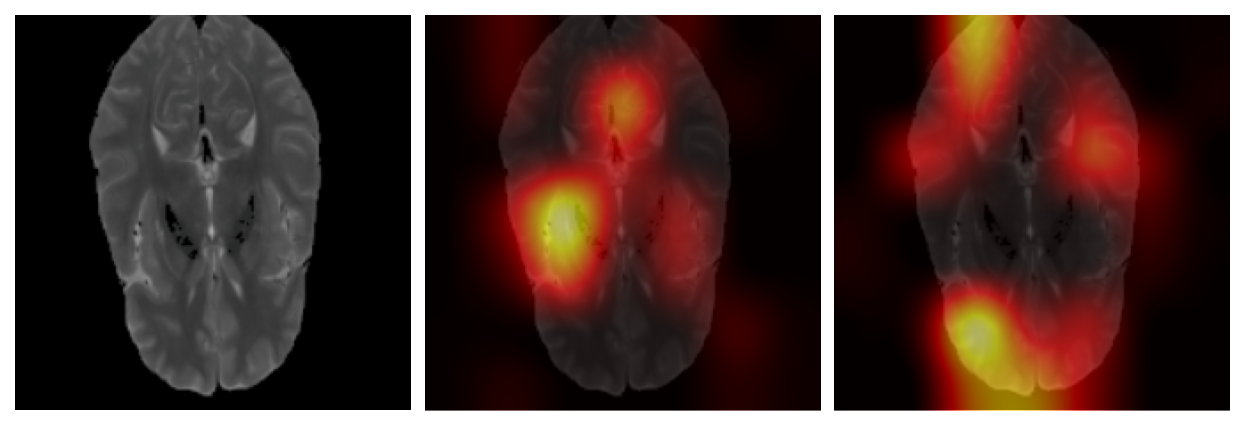

In [67]:

plot_gradcam(x_img,learn1,target_layer)